In [135]:
import math
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [257]:
# initial parameters
up = 1
low = -1
dim = 2
mesh_size = 200
bound_size = 10000
#
u_layer = 6
u_hidden_size = 20
u_step = 1
u_rate = 0.015
v_layer = 6
v_hidden_size = 20
v_step = 1       
v_rate = 0.02  
out_size = 1
alpha = 25


# x_boundary
x_boundary_list=[]  #x_boundry
x_bound_1 = torch.Tensor(bound_size,1).uniform_(low,up)
x_bound_2 = torch.sqrt(1-x_bound_1**2)
x_bound_3 = -torch.sqrt(1-x_bound_1**2)
x_bound_4 = torch.Tensor(bound_size,1).uniform_(low,up)
x_bound_5 = torch.sqrt(1-x_bound_4**2)
x_bound_6 = -torch.sqrt(1-x_bound_4**2)
#
x_boundary_list.append(torch.cat((x_bound_1,x_bound_2),1))
x_boundary_list.append(torch.cat((x_bound_1,x_bound_3),1))
x_boundary_list.append(torch.cat((x_bound_5,x_bound_4),1))
x_boundary_list.append(torch.cat((x_bound_6,x_bound_4),1))
x_boundary = torch.cat((x_boundary_list[0],x_boundary_list[1], x_boundary_list[2], x_boundary_list[3]),0)


# x value for network input
x_mesh = torch.linspace(low,up,mesh_size)
y_mesh=torch.Tensor(mesh_size,mesh_size)
for i in range(mesh_size):
    neg=-torch.sqrt(1-x_mesh[i]**2)
    pos=torch.sqrt(1-x_mesh[i]**2)
    y_mesh[i,:]=torch.linspace(neg.data.float(),pos.data.float(),mesh_size)
mesh1,mesh2=torch.meshgrid(x_mesh,x_mesh)
x_mesh_=torch.reshape(mesh1,(-1,1))
y_mesh_=torch.reshape(y_mesh,(-1,1))
x_test=torch.cat((x_mesh_,y_mesh_),1)

In [258]:
# exact solution u(x) for pde
def func_u(x):
    lens=x.shape[0]
    u=torch.Tensor(lens,1)
    for i in range(lens):
        u[i]=(1-(x[i,0]**2)-(x[i,1]**2))/4
    return (u) 

def func_f(x):
    f = 1
    return (f)

def func_g(x):
    g = 0
    return (g)

def func_w(x):
    lens = x.shape[0]
    w_bool = torch.gt(torch.zeros(lens), 1-(x[:,0]**2+x[:,1]**2))
    w_val = torch.where(w_bool, 1-(x[:,0]**2+x[:,1]**2), torch.zeros(lens))
    return (w_val)

In [259]:
# define generator and discriminator neural network
class generator(torch.nn.Module):
    def __init__(self):
        super(generator,self).__init__()
        self.layer = torch.nn.Linear(dim, out_size)

    def forward(self, x):
        y=self.layer(x**2)
        return(y)

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return(self.loss)

    
class discriminator(torch.nn.Module):
    def __init__(self):
        super(discriminator,self).__init__()
        self.hidden00_v=torch.nn.Linear(dim, v_hidden_size)
        self.hidden0_v=torch.nn.Linear(v_hidden_size, v_hidden_size)
        self.hidden1_v=torch.nn.Linear(v_hidden_size, v_hidden_size)
        self.hidden2_v=torch.nn.Linear(v_hidden_size, v_hidden_size)
        self.hidden3_v=torch.nn.Linear(v_hidden_size, v_hidden_size)
        self.hidden4_v=torch.nn.Linear(v_hidden_size, v_hidden_size)
        self.hidden5_v=torch.nn.Linear(v_hidden_size, v_hidden_size)
        self.hidden6_v=torch.nn.Linear(v_hidden_size, v_hidden_size)
        self.predict_v=torch.nn.Linear(v_hidden_size, out_size)

    def forward(self, x):
        x=torch.tanh(self.hidden00_v(x))
        x=torch.tanh(self.hidden0_v(x))
        x=F.softplus(self.hidden1_v(x))
        x=torch.sin(self.hidden2_v(x))
        x=F.softplus(self.hidden3_v(x))
        x=torch.sin(self.hidden4_v(x))
        x=F.softplus(self.hidden5_v(x))
        x=torch.sin(self.hidden6_v(x))
        x=self.predict_v(x)
        return(x)

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return(self.loss)

In [260]:
# grad_u
def grad_u(y_output_u):
    optimizer_u_0.zero_grad()
    lens = x_test.shape[0]
    y_output_u.backward(torch.ones([lens,1]), retain_graph=True)
    grad_u = x_test_.grad
    return(grad_u)

# grad_phi
def grad_phi(y_output_v):
    optimizer_v_0.zero_grad()
    lens = x_test.shape[0]
    w = torch.reshape(func_w(x_test_), (lens, 1))
    phi = y_output_v.mul(w)
    phi.backward(torch.ones([lens, 1]), retain_graph=True)
    grad_phi = x_test_.grad
    return (grad_phi)


# loss function
def I(y_output_u, y_output_v):
    temp_grad_u=grad_u(y_output_u)
    t1 = torch.sum(torch.mm(torch.transpose(temp_grad_u,0,1),grad_phi(y_output_v)))
    t = torch.sum(func_f(x_test)*y_output_v)
    I = t1-t
    return(I)

def L_int(y_output_u, y_output_v):
    numerator = torch.log(torch.abs(I(y_output_u, y_output_v))**2)
    denominator = torch.log(torch.sum((y_output_v)**2)) #net_v(x_domain)
    ratio=numerator-denominator
    return(ratio)

def L_bd():
    result = torch.mean((net_u(x_boundary_)-func_g(x_boundary))**2)
    return(result)

def Loss_u(y_output_u, y_output_v):
    return(L_int(y_output_u, y_output_v)+25*L_bd())

def Loss_v(y_output_u,y_output_v):
    return(-L_int(y_output_u, y_output_v))

In [261]:
# torch variables
x_test_ = Variable(x_test)
x_test_.requires_grad_(True)
x_boundary_ = Variable(x_boundary)
x_test_.requires_grad_(True)
u_test = func_u(x_test)
u_test_ = Variable(u_test)

# neural network models
net_u = generator()
net_v = discriminator()

# optimizers for grad_u and grad_phi
optimizer_u_0 = torch.optim.SGD(net_u.parameters(), lr = 0)
optimizer_v_0 = torch.optim.SGD(net_v.parameters(), lr = 0)

#optimizers for WAN
optimizer_u = torch.optim.Adam(net_u.parameters(), lr = u_rate) 
optimizer_v = torch.optim.Adam(net_v.parameters(), lr = v_rate)  

In [262]:
iteration = 201
n1 = 20
n2 = 20

prediction_u = net_u(x_test_)
prediction_v = net_v(x_test_)


for t in range(iteration):
       
        
    for i in range(n1):
        loss_u = Loss_u(prediction_u, prediction_v)
        optimizer_u.zero_grad()
        loss_u.backward(retain_graph=True)
        optimizer_u.step()
        prediction_u = net_u(x_test_)
        
    
    for j in range(n2):
        loss_v = Loss_v(prediction_u, prediction_v)
        optimizer_v.zero_grad()
        loss_v.backward(retain_graph=True)
        optimizer_v.step()
        prediction_v = net_v(x_test_)
            

    if t%10==0:
        print(t, loss_u, loss_v)
        print('第%d个epoch的学习率：%f'%(t, optimizer_u.param_groups[0]['lr']))
        print('第%d个epoch的学习率：%f'%(t, optimizer_v.param_groups[0]['lr']))

0 tensor(22.2302, grad_fn=<AddBackward0>) tensor(-21.4893, grad_fn=<NegBackward>)
第0个epoch的学习率：0.015000
第0个epoch的学习率：0.020000
10 tensor(32.0621, grad_fn=<AddBackward0>) tensor(-33.1474, grad_fn=<NegBackward>)
第10个epoch的学习率：0.015000
第10个epoch的学习率：0.020000
20 tensor(34.7019, grad_fn=<AddBackward0>) tensor(-35.2925, grad_fn=<NegBackward>)
第20个epoch的学习率：0.015000
第20个epoch的学习率：0.020000
30 tensor(37.9864, grad_fn=<AddBackward0>) tensor(-38.1289, grad_fn=<NegBackward>)
第30个epoch的学习率：0.015000
第30个epoch的学习率：0.020000
40 tensor(37.5091, grad_fn=<AddBackward0>) tensor(-34.7255, grad_fn=<NegBackward>)
第40个epoch的学习率：0.015000
第40个epoch的学习率：0.020000
50 tensor(36.0430, grad_fn=<AddBackward0>) tensor(-40.8334, grad_fn=<NegBackward>)
第50个epoch的学习率：0.015000
第50个epoch的学习率：0.020000
60 tensor(41.1442, grad_fn=<AddBackward0>) tensor(-38.3530, grad_fn=<NegBackward>)
第60个epoch的学习率：0.015000
第60个epoch的学习率：0.020000
70 tensor(40.0075, grad_fn=<AddBackward0>) tensor(-45.7508, grad_fn=<NegBackward>)
第70个epoch的学习率：0.0

In [263]:
optimizer_u.param_groups

[{'params': [Parameter containing:
   tensor([[-0.2346, -0.2346]], requires_grad=True), Parameter containing:
   tensor([0.2346], requires_grad=True)],
  'lr': 0.015,
  'betas': (0.9, 0.999),
  'eps': 1e-08,
  'weight_decay': 0,
  'amsgrad': False}]

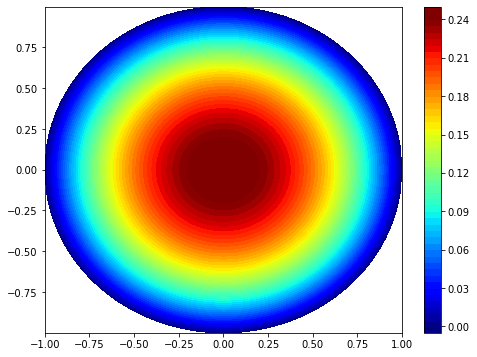

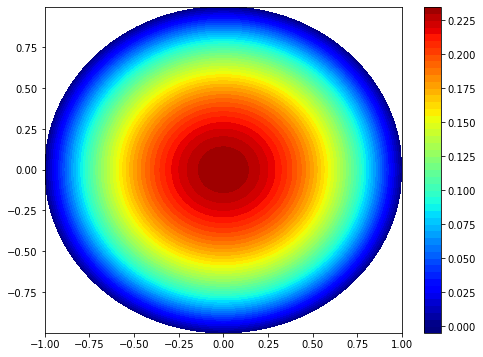

In [264]:
test_u_=torch.reshape(u_test_,(mesh_size,mesh_size))
#设置打开画布大小,长8，宽6
plt.figure(figsize=(8,6))
#填充颜色，f即filled
cset=plt.contourf(mesh1.data.numpy(), y_mesh.data.numpy(),test_u_.data.numpy(), 50, cmap="jet")
#画等高线
#plt.contour(x1,x2,test_u_,50)
#设置颜色条
plt.clim(0.00, 0.24)
plt.colorbar(cset)
plt.show()

prediciton_u_=torch.reshape(prediction_u.data,(mesh_size,mesh_size))
#设置打开画布大小,长8，宽6
plt.figure(figsize=(8,6))
#填充颜色，f即filled
cset=plt.contourf(mesh1.data.numpy(),y_mesh.data.numpy(),prediciton_u_.data.numpy(), 50, cmap="jet")
#画等高线
#plt.contour(x1,x2,test_u_,50)
#设置颜色
plt.clim(0.00, 0.24)
plt.colorbar(cset)
plt.show()

In [265]:
iteration = 201
n1 = 20
n2 = 20

prediction_u = net_u(x_test_)
prediction_v = net_v(x_test_)


for t in range(iteration):
       
        
    for i in range(n1):
        loss_u = Loss_u(prediction_u, prediction_v)
        optimizer_u.zero_grad()
        loss_u.backward(retain_graph=True)
        optimizer_u.step()
        prediction_u = net_u(x_test_)
        
    
    for j in range(n2):
        loss_v = Loss_v(prediction_u, prediction_v)
        optimizer_v.zero_grad()
        loss_v.backward(retain_graph=True)
        optimizer_v.step()
        prediction_v = net_v(x_test_)
            

    if t%10==0:
        print(t, loss_u, loss_v)
        print('第%d个epoch的学习率：%f'%(t, optimizer_u.param_groups[0]['lr']))
        print('第%d个epoch的学习率：%f'%(t, optimizer_v.param_groups[0]['lr']))

0 tensor(41.1821, grad_fn=<AddBackward0>) tensor(-41.3635, grad_fn=<NegBackward>)
第0个epoch的学习率：0.015000
第0个epoch的学习率：0.020000
10 tensor(43.4453, grad_fn=<AddBackward0>) tensor(-43.8870, grad_fn=<NegBackward>)
第10个epoch的学习率：0.015000
第10个epoch的学习率：0.020000
20 tensor(41.9441, grad_fn=<AddBackward0>) tensor(-42.1576, grad_fn=<NegBackward>)
第20个epoch的学习率：0.015000
第20个epoch的学习率：0.020000
30 tensor(43.9316, grad_fn=<AddBackward0>) tensor(-44.3166, grad_fn=<NegBackward>)
第30个epoch的学习率：0.015000
第30个epoch的学习率：0.020000
40 tensor(43.5968, grad_fn=<AddBackward0>) tensor(-42.9761, grad_fn=<NegBackward>)
第40个epoch的学习率：0.015000
第40个epoch的学习率：0.020000
50 tensor(45.4693, grad_fn=<AddBackward0>) tensor(-46.7474, grad_fn=<NegBackward>)
第50个epoch的学习率：0.015000
第50个epoch的学习率：0.020000
60 tensor(44.7144, grad_fn=<AddBackward0>) tensor(-43.6386, grad_fn=<NegBackward>)
第60个epoch的学习率：0.015000
第60个epoch的学习率：0.020000
70 tensor(48.8149, grad_fn=<AddBackward0>) tensor(-44.0243, grad_fn=<NegBackward>)
第70个epoch的学习率：0.0

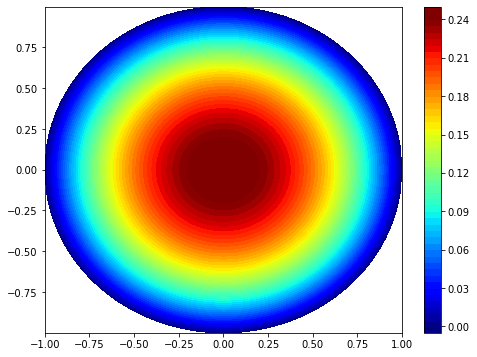

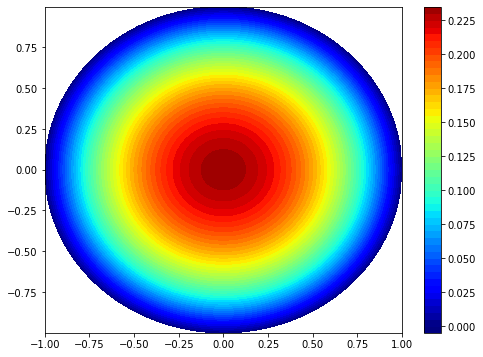

In [266]:
test_u_=torch.reshape(u_test_,(mesh_size,mesh_size))
#设置打开画布大小,长8，宽6
plt.figure(figsize=(8,6))
#填充颜色，f即filled
cset=plt.contourf(mesh1.data.numpy(), y_mesh.data.numpy(),test_u_.data.numpy(), 50, cmap="jet")
#画等高线
#plt.contour(x1,x2,test_u_,50)
#设置颜色条
plt.clim(0.00, 0.24)
plt.colorbar(cset)
plt.show()

prediciton_u_=torch.reshape(prediction_u.data,(mesh_size,mesh_size))
#设置打开画布大小,长8，宽6
plt.figure(figsize=(8,6))
#填充颜色，f即filled
cset=plt.contourf(mesh1.data.numpy(),y_mesh.data.numpy(),prediciton_u_.data.numpy(), 50, cmap="jet")
#画等高线
#plt.contour(x1,x2,test_u_,50)
#设置颜色
plt.clim(0.00, 0.24)
plt.colorbar(cset)
plt.show()

In [267]:
iteration = 201
n1 = 20
n2 = 20

prediction_u = net_u(x_test_)
prediction_v = net_v(x_test_)


for t in range(iteration):
       
        
    for i in range(n1):
        loss_u = Loss_u(prediction_u, prediction_v)
        optimizer_u.zero_grad()
        loss_u.backward(retain_graph=True)
        optimizer_u.step()
        prediction_u = net_u(x_test_)
        
    
    for j in range(n2):
        loss_v = Loss_v(prediction_u, prediction_v)
        optimizer_v.zero_grad()
        loss_v.backward(retain_graph=True)
        optimizer_v.step()
        prediction_v = net_v(x_test_)
            

    if t%10==0:
        print(t, loss_u, loss_v)
        print('第%d个epoch的学习率：%f'%(t, optimizer_u.param_groups[0]['lr']))
        print('第%d个epoch的学习率：%f'%(t, optimizer_v.param_groups[0]['lr']))

0 tensor(42.3628, grad_fn=<AddBackward0>) tensor(-42.4393, grad_fn=<NegBackward>)
第0个epoch的学习率：0.015000
第0个epoch的学习率：0.020000
10 tensor(44.0094, grad_fn=<AddBackward0>) tensor(-44.5779, grad_fn=<NegBackward>)
第10个epoch的学习率：0.015000
第10个epoch的学习率：0.020000
20 tensor(44.2593, grad_fn=<AddBackward0>) tensor(-44.7292, grad_fn=<NegBackward>)
第20个epoch的学习率：0.015000
第20个epoch的学习率：0.020000
30 tensor(42.2148, grad_fn=<AddBackward0>) tensor(-42.2848, grad_fn=<NegBackward>)
第30个epoch的学习率：0.015000
第30个epoch的学习率：0.020000
40 tensor(42.4423, grad_fn=<AddBackward0>) tensor(-48.8262, grad_fn=<NegBackward>)
第40个epoch的学习率：0.015000
第40个epoch的学习率：0.020000
50 tensor(47.0186, grad_fn=<AddBackward0>) tensor(-44.4919, grad_fn=<NegBackward>)
第50个epoch的学习率：0.015000
第50个epoch的学习率：0.020000
60 tensor(45.0425, grad_fn=<AddBackward0>) tensor(-43.4700, grad_fn=<NegBackward>)
第60个epoch的学习率：0.015000
第60个epoch的学习率：0.020000
70 tensor(41.1231, grad_fn=<AddBackward0>) tensor(-41.1375, grad_fn=<NegBackward>)
第70个epoch的学习率：0.0

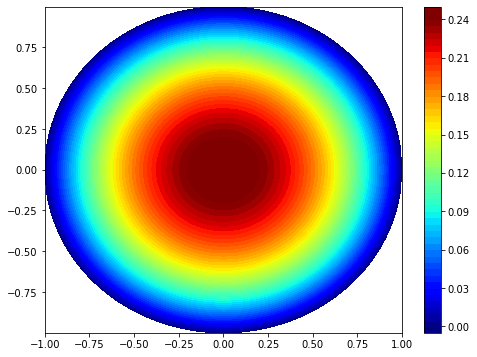

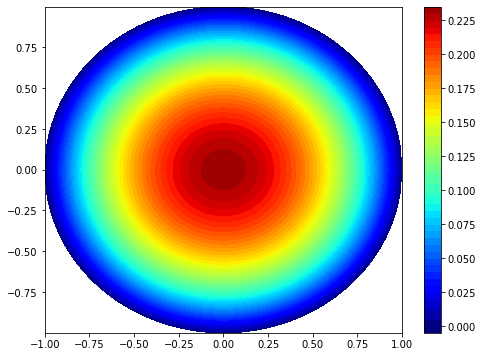

In [268]:
test_u_=torch.reshape(u_test_,(mesh_size,mesh_size))
#设置打开画布大小,长8，宽6
plt.figure(figsize=(8,6))
#填充颜色，f即filled
cset=plt.contourf(mesh1.data.numpy(), y_mesh.data.numpy(),test_u_.data.numpy(), 50, cmap="jet")
#画等高线
#plt.contour(x1,x2,test_u_,50)
#设置颜色条
plt.clim(0.00, 0.24)
plt.colorbar(cset)
plt.show()

prediciton_u_=torch.reshape(prediction_u.data,(mesh_size,mesh_size))
#设置打开画布大小,长8，宽6
plt.figure(figsize=(8,6))
#填充颜色，f即filled
cset=plt.contourf(mesh1.data.numpy(),y_mesh.data.numpy(),prediciton_u_.data.numpy(), 50, cmap="jet")
#画等高线
#plt.contour(x1,x2,test_u_,50)
#设置颜色
plt.clim(0.00, 0.24)
plt.colorbar(cset)
plt.show()

In [269]:
# error
lens=x_test.shape[0]
error_test = torch.Tensor(lens,1)
for i in range(lens):
  error_test[i] = torch.sqrt((torch.square(u_test.data[i]-prediction_u.data[i]))) 

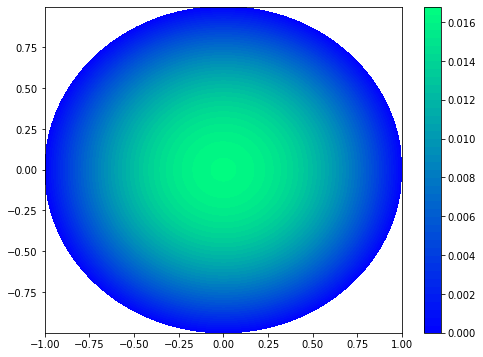

In [277]:
error_test_=torch.reshape(error_test,(mesh_size,mesh_size))
#设置打开画布大小,长8，宽6
plt.figure(figsize=(8,6))
#填充颜色，f即filled
cset=plt.contourf(mesh1.data.numpy(),y_mesh.data.numpy(),error_test_.data.numpy(), 50, cmap="winter")
#画等高线
#plt.contour(x1,x2,test_u_,50)
#设置颜色条
#plt.clim(0.00, 0.24)
plt.colorbar(cset)
plt.show()

In [276]:
# save data
import os
import scipy.io

file_path= '/Users/mac/Desktop/'
data_save = {}
data_save['mesh_x'] = mesh1.data.numpy()
data_save['mesh_y'] = y_mesh.data.numpy()
data_save['test_u'] = test_u_.data.numpy()
data_save['prediction_u'] = prediction_u.data.numpy()
data_save['error'] = error_test.data.numpy()

# save data as .mat form
scipy.io.savemat(file_path+'unit_disk_quadratic', data_save)
print('Data saved in '+file_path)

Data saved in /Users/mac/Desktop/
